In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
from scipy.stats import chi2_contingency, pointbiserialr
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB

In [3]:
hair = pd.read_csv('Predict Hair Fall.csv')

In [4]:
hair.head()

,Id,Genetics,Hormonal Changes,Medical Conditions,Medications & Treatments,Nutritional Deficiencies,Stress,Age,Poor Hair Care Habits,Environmental Factors,Smoking,Weight Loss,Hair Loss
0,133992,Yes,No,No Data,No Data,Magnesium deficiency,Moderate,19,Yes,Yes,No,No,0
1,148393,No,No,Eczema,Antibiotics,Magnesium deficiency,High,43,Yes,Yes,No,No,0
2,155074,No,No,Dermatosis,Antifungal Cream,Protein deficiency,Moderate,26,Yes,Yes,No,Yes,0
3,118261,Yes,Yes,Ringworm,Antibiotics,Biotin Deficiency,Moderate,46,Yes,Yes,No,No,0
4,111915,No,No,Psoriasis,Accutane,Iron deficiency,Moderate,30,No,Yes,Yes,No,1


In [5]:
hair.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Id                         999 non-null    int64 
 1   Genetics                   999 non-null    object
 2   Hormonal Changes           999 non-null    object
 3   Medical Conditions         999 non-null    object
 4   Medications & Treatments   999 non-null    object
 5   Nutritional Deficiencies   999 non-null    object
 6   Stress                     999 non-null    object
 7   Age                        999 non-null    int64 
 8   Poor Hair Care Habits      999 non-null    object
 9   Environmental Factors      999 non-null    object
 10  Smoking                    999 non-null    object
 11  Weight Loss                999 non-null    object
 12  Hair Loss                  999 non-null    int64 
dtypes: int64(3), object(10)
memory usage: 101.6+ KB


At the beginning we can remove Id column, is useful for our analysis 

In [6]:
hair.columns = hair.columns.str.strip().str.replace(' ', '_')
hair.rename(columns = {'Medications_&_Treatments':'Medications&Treatments'}, inplace = True)

In [7]:
hair.drop('Id', axis = 1, inplace = True)

In [8]:
hair.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Genetics                  999 non-null    object
 1   Hormonal_Changes          999 non-null    object
 2   Medical_Conditions        999 non-null    object
 3   Medications&Treatments    999 non-null    object
 4   Nutritional_Deficiencies  999 non-null    object
 5   Stress                    999 non-null    object
 6   Age                       999 non-null    int64 
 7   Poor_Hair_Care_Habits     999 non-null    object
 8   Environmental_Factors     999 non-null    object
 9   Smoking                   999 non-null    object
 10  Weight_Loss               999 non-null    object
 11  Hair_Loss                 999 non-null    int64 
dtypes: int64(2), object(10)
memory usage: 93.8+ KB


In [9]:
hair.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,999.0,34.188188,9.377980,18.0,26.0,34.0,42.0,50.0
Hair_Loss,999.0,0.497497,0.500244,0.0,0.0,0.0,1.0,1.0


We don't have any null values so work in this field is not required

In [10]:
hair.isna().sum()

Genetics                    0
Hormonal_Changes            0
Medical_Conditions          0
Medications&Treatments      0
Nutritional_Deficiencies    0
Stress                      0
Age                         0
Poor_Hair_Care_Habits       0
Environmental_Factors       0
Smoking                     0
Weight_Loss                 0
Hair_Loss                   0
dtype: int64

In [11]:
hair[hair.duplicated()]

,Genetics,Hormonal_Changes,Medical_Conditions,Medications&Treatments,Nutritional_Deficiencies,Stress,Age,Poor_Hair_Care_Habits,Environmental_Factors,Smoking,Weight_Loss,Hair_Loss
406,Yes,No,No Data,Antidepressants,Selenium deficiency,High,18,Yes,No,No,Yes,1


In [12]:
hair.drop_duplicates(inplace=True, ignore_index=True)

In [13]:
hair.duplicated().sum()

0

In [14]:
counts =  hair['Hair_Loss'].value_counts()

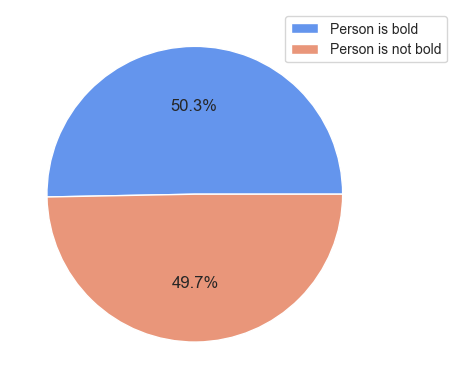

In [15]:
sns.set_style("whitegrid")
plt.pie(counts, autopct='%1.1f%%',colors = ['cornflowerblue','darksalmon'], 
         textprops={'fontsize': 12})
plt.legend(labels = ['Person is bold', 'Person is not bold'], bbox_to_anchor=(1.2, 1.0))

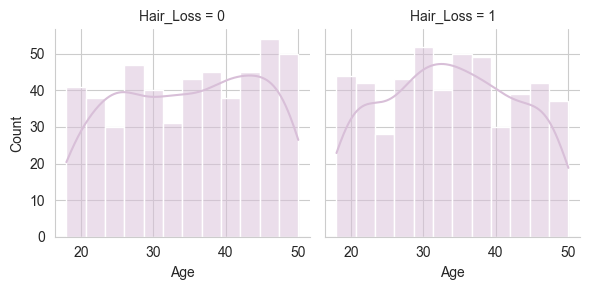

In [16]:
canvas = sns.FacetGrid(hair, col='Hair_Loss')
canvas.map(sns.histplot, 'Age', bins = 12, color = 'thistle', kde = True)

<Axes: xlabel='Stress', ylabel='count'>

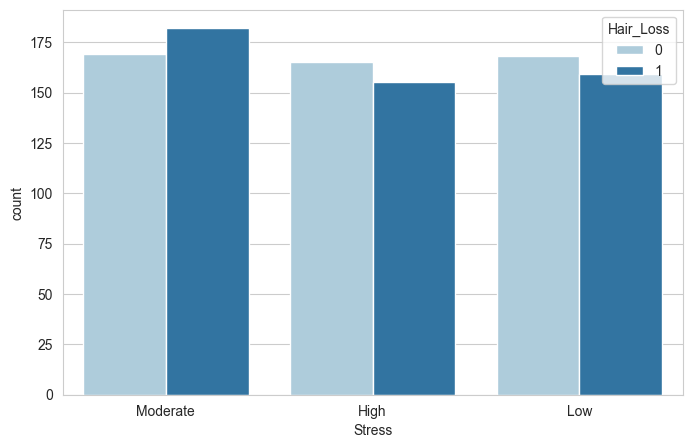

In [17]:
plt.figure(figsize = (8,5))
sns.countplot(hair, x= 'Stress', hue = 'Hair_Loss', palette = 'Paired')

<Axes: xlabel='count', ylabel='Medical_Conditions'>

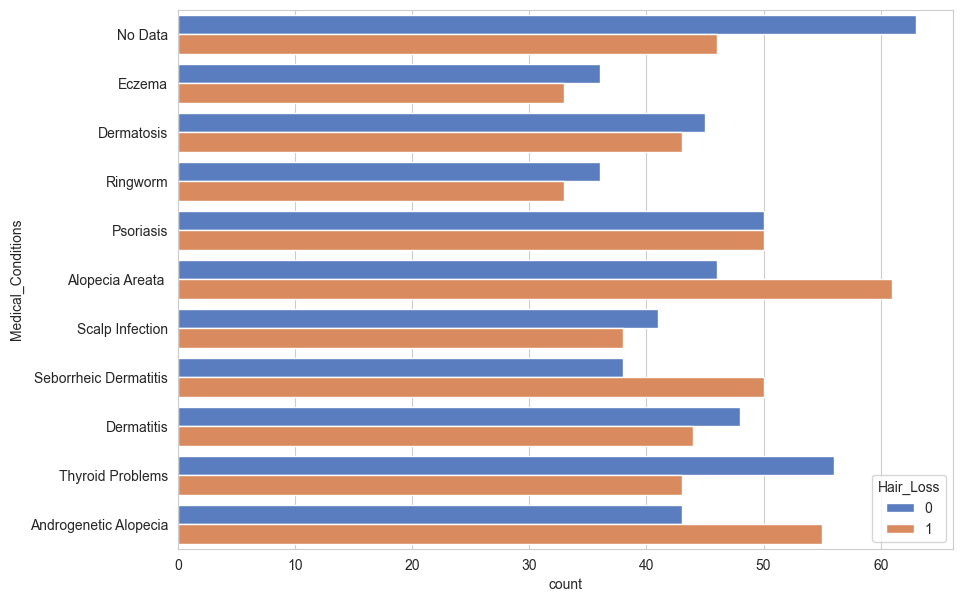

In [18]:
plt.figure(figsize=(10, 7))
sns.countplot(hair, y = 'Medical_Conditions', hue = 'Hair_Loss', palette = 'muted')

<Axes: xlabel='count', ylabel='Medications&Treatments'>

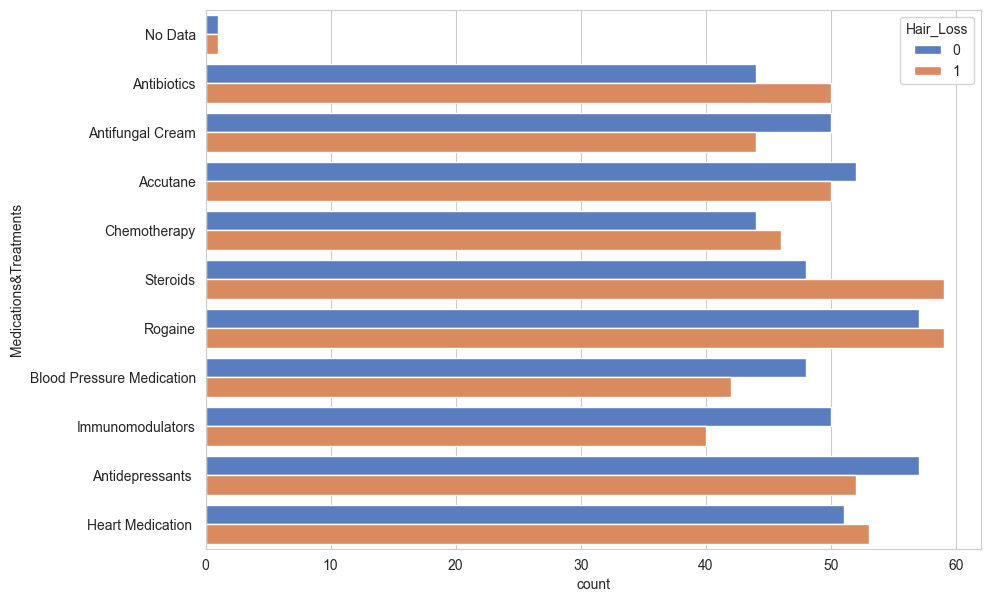

In [19]:
plt.figure(figsize=(10, 7))
sns.countplot(hair, y = 'Medications&Treatments', hue = 'Hair_Loss', palette = 'muted')

<Axes: xlabel='count', ylabel='Nutritional_Deficiencies'>

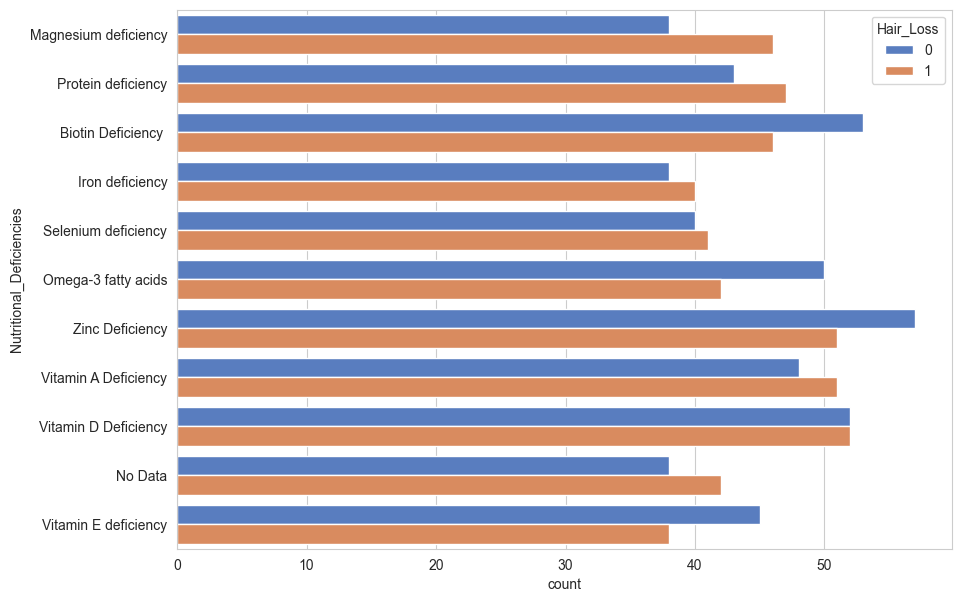

In [20]:
plt.figure(figsize=(10, 7))
sns.countplot(hair, y = 'Nutritional_Deficiencies', hue = 'Hair_Loss', palette = 'muted')

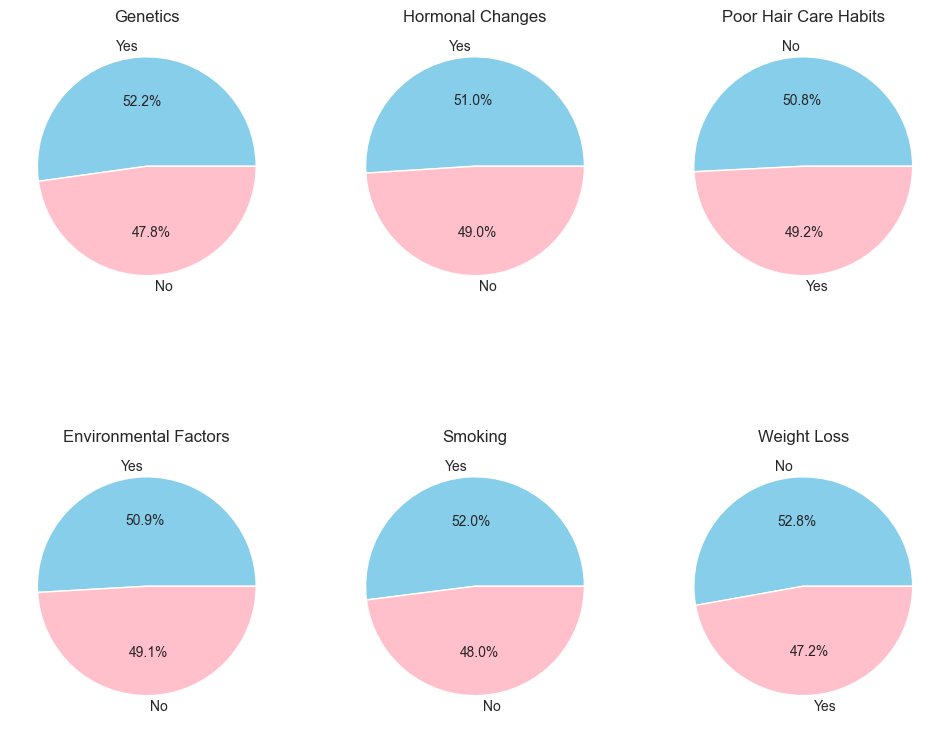

In [21]:
categorical = ['Genetics', 'Hormonal_Changes', 'Poor_Hair_Care_Habits', 'Environmental_Factors', 'Smoking', 'Weight_Loss']

fig, axes = plt.subplots(2, 3, figsize=(12, 10))  

for ax, category in zip(axes.flatten(), categorical):
    counts = hair[category].value_counts()
    ax.pie(counts, labels=counts.index, autopct='%1.1f%%', colors=['skyblue', 'pink'])
    ax.set_title(category.replace('_', ' '))

In [22]:
hair.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Genetics                  998 non-null    object
 1   Hormonal_Changes          998 non-null    object
 2   Medical_Conditions        998 non-null    object
 3   Medications&Treatments    998 non-null    object
 4   Nutritional_Deficiencies  998 non-null    object
 5   Stress                    998 non-null    object
 6   Age                       998 non-null    int64 
 7   Poor_Hair_Care_Habits     998 non-null    object
 8   Environmental_Factors     998 non-null    object
 9   Smoking                   998 non-null    object
 10  Weight_Loss               998 non-null    object
 11  Hair_Loss                 998 non-null    int64 
dtypes: int64(2), object(10)
memory usage: 93.7+ KB


In [23]:
hair.apply(lambda x: x.unique())

Genetics                                                            [Yes, No]
Hormonal_Changes                                                    [No, Yes]
Medical_Conditions          [No Data, Eczema, Dermatosis, Ringworm, Psoria...
Medications&Treatments      [No Data, Antibiotics, Antifungal Cream, Accut...
Nutritional_Deficiencies    [Magnesium deficiency, Protein deficiency, Bio...
Stress                                                  [Moderate, High, Low]
Age                         [19, 43, 26, 46, 30, 37, 40, 35, 49, 48, 20, 3...
Poor_Hair_Care_Habits                                               [Yes, No]
Environmental_Factors                                               [Yes, No]
Smoking                                                             [No, Yes]
Weight_Loss                                                         [No, Yes]
Hair_Loss                                                              [0, 1]
dtype: object

Let's change all yes no columns to binary

In [24]:
binary_columns = ['Genetics', 'Hormonal_Changes', 'Poor_Hair_Care_Habits', 'Environmental_Factors', 'Smoking', 'Weight_Loss']

def change_colums(df, columns):
    for column in columns:
        df[column] = df[column].map({'Yes':1, 'No':0})
change_colums(hair,binary_columns)

In [25]:
hair.apply(lambda x: x.unique())

Genetics                                                               [1, 0]
Hormonal_Changes                                                       [0, 1]
Medical_Conditions          [No Data, Eczema, Dermatosis, Ringworm, Psoria...
Medications&Treatments      [No Data, Antibiotics, Antifungal Cream, Accut...
Nutritional_Deficiencies    [Magnesium deficiency, Protein deficiency, Bio...
Stress                                                  [Moderate, High, Low]
Age                         [19, 43, 26, 46, 30, 37, 40, 35, 49, 48, 20, 3...
Poor_Hair_Care_Habits                                                  [1, 0]
Environmental_Factors                                                  [1, 0]
Smoking                                                                [0, 1]
Weight_Loss                                                            [0, 1]
Hair_Loss                                                              [0, 1]
dtype: object

Modifiaction column with order - Stress                                                  

In [26]:
hair['Stress'] = hair['Stress'].map({'Low': 1, 'Moderate' : 2, 'High' : 3})

In [27]:
hair.apply(lambda x: x.unique())

Genetics                                                               [1, 0]
Hormonal_Changes                                                       [0, 1]
Medical_Conditions          [No Data, Eczema, Dermatosis, Ringworm, Psoria...
Medications&Treatments      [No Data, Antibiotics, Antifungal Cream, Accut...
Nutritional_Deficiencies    [Magnesium deficiency, Protein deficiency, Bio...
Stress                                                              [2, 3, 1]
Age                         [19, 43, 26, 46, 30, 37, 40, 35, 49, 48, 20, 3...
Poor_Hair_Care_Habits                                                  [1, 0]
Environmental_Factors                                                  [1, 0]
Smoking                                                                [0, 1]
Weight_Loss                                                            [0, 1]
Hair_Loss                                                              [0, 1]
dtype: object

In [28]:
hair['Medical_Conditions'].value_counts()

Medical_Conditions
No Data                  109
Alopecia Areata          107
Psoriasis                100
Thyroid Problems          99
Androgenetic Alopecia     98
Dermatitis                92
Dermatosis                88
Seborrheic Dermatitis     88
Scalp Infection           79
Eczema                    69
Ringworm                  69
Name: count, dtype: int64

In [29]:
hair['Medications&Treatments'].value_counts()

Medications&Treatments
Rogaine                      116
Antidepressants              109
Steroids                     107
Heart Medication             104
Accutane                     102
Antibiotics                   94
Antifungal Cream              94
Chemotherapy                  90
Blood Pressure Medication     90
Immunomodulators              90
No Data                        2
Name: count, dtype: int64

In [30]:
hair['Nutritional_Deficiencies'].value_counts()

Nutritional_Deficiencies
Zinc Deficiency         108
Vitamin D Deficiency    104
Biotin Deficiency        99
Vitamin A Deficiency     99
Omega-3 fatty acids      92
Protein deficiency       90
Magnesium deficiency     84
Vitamin E deficiency     83
Selenium deficiency      81
No Data                  80
Iron deficiency          78
Name: count, dtype: int64

In [31]:
hair = pd.get_dummies(hair,columns = ['Nutritional_Deficiencies','Medications&Treatments', 'Medical_Conditions'],drop_first=True )

In [32]:
hair.columns

Index(['Genetics', 'Hormonal_Changes', 'Stress', 'Age',
       'Poor_Hair_Care_Habits', 'Environmental_Factors', 'Smoking',
       'Weight_Loss', 'Hair_Loss', 'Nutritional_Deficiencies_Iron deficiency',
       'Nutritional_Deficiencies_Magnesium deficiency',
       'Nutritional_Deficiencies_No Data',
       'Nutritional_Deficiencies_Omega-3 fatty acids',
       'Nutritional_Deficiencies_Protein deficiency',
       'Nutritional_Deficiencies_Selenium deficiency',
       'Nutritional_Deficiencies_Vitamin A Deficiency',
       'Nutritional_Deficiencies_Vitamin D Deficiency',
       'Nutritional_Deficiencies_Vitamin E deficiency',
       'Nutritional_Deficiencies_Zinc Deficiency',
       'Medications&Treatments_Antibiotics',
       'Medications&Treatments_Antidepressants ',
       'Medications&Treatments_Antifungal Cream',
       'Medications&Treatments_Blood Pressure Medication',
       'Medications&Treatments_Chemotherapy',
       'Medications&Treatments_Heart Medication ',
       'Medica

In [33]:
hair = hair.loc[:, ~hair.columns.str.contains('No Data')]

In [34]:
hair.columns

Index(['Genetics', 'Hormonal_Changes', 'Stress', 'Age',
       'Poor_Hair_Care_Habits', 'Environmental_Factors', 'Smoking',
       'Weight_Loss', 'Hair_Loss', 'Nutritional_Deficiencies_Iron deficiency',
       'Nutritional_Deficiencies_Magnesium deficiency',
       'Nutritional_Deficiencies_Omega-3 fatty acids',
       'Nutritional_Deficiencies_Protein deficiency',
       'Nutritional_Deficiencies_Selenium deficiency',
       'Nutritional_Deficiencies_Vitamin A Deficiency',
       'Nutritional_Deficiencies_Vitamin D Deficiency',
       'Nutritional_Deficiencies_Vitamin E deficiency',
       'Nutritional_Deficiencies_Zinc Deficiency',
       'Medications&Treatments_Antibiotics',
       'Medications&Treatments_Antidepressants ',
       'Medications&Treatments_Antifungal Cream',
       'Medications&Treatments_Blood Pressure Medication',
       'Medications&Treatments_Chemotherapy',
       'Medications&Treatments_Heart Medication ',
       'Medications&Treatments_Immunomodulators',
       

In [35]:
hair.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 36 columns):
 #   Column                                            Non-Null Count  Dtype
---  ------                                            --------------  -----
 0   Genetics                                          998 non-null    int64
 1   Hormonal_Changes                                  998 non-null    int64
 2   Stress                                            998 non-null    int64
 3   Age                                               998 non-null    int64
 4   Poor_Hair_Care_Habits                             998 non-null    int64
 5   Environmental_Factors                             998 non-null    int64
 6   Smoking                                           998 non-null    int64
 7   Weight_Loss                                       998 non-null    int64
 8   Hair_Loss                                         998 non-null    int64
 9   Nutritional_Deficiencies_Iron deficiency   

In [36]:
hair.head()

,Genetics,Hormonal_Changes,Stress,Age,Poor_Hair_Care_Habits,Environmental_Factors,Smoking,Weight_Loss,Hair_Loss,Nutritional_Deficiencies_Iron deficiency,...,Medications&Treatments_Steroids,Medical_Conditions_Androgenetic Alopecia,Medical_Conditions_Dermatitis,Medical_Conditions_Dermatosis,Medical_Conditions_Eczema,Medical_Conditions_Psoriasis,Medical_Conditions_Ringworm,Medical_Conditions_Scalp Infection,Medical_Conditions_Seborrheic Dermatitis,Medical_Conditions_Thyroid Problems
0,1,0,2,19,1,1,0,0,0,False,...,False,False,False,False,False,False,False,False,False,False
1,0,0,3,43,1,1,0,0,0,False,...,False,False,False,False,True,False,False,False,False,False
2,0,0,2,26,1,1,0,1,0,False,...,False,False,False,True,False,False,False,False,False,False
3,1,1,2,46,1,1,0,0,0,False,...,False,False,False,False,False,False,True,False,False,False
4,0,0,2,30,0,1,1,0,1,True,...,False,False,False,False,False,True,False,False,False,False


In [37]:
ref = 'Hair_Loss'
selected = hair.drop(['Age','Hair_Loss' ],axis = 1)
result_list = []

for col in selected.columns:
    if col != ref:
        contingency_table = pd.crosstab(hair[ref], selected[col])
        chi2, p, dof, _ = chi2_contingency(contingency_table)
        result_list.append({'Zmienna': col, 'Chi2': chi2, 'p-value': p})
result_df = pd.DataFrame(result_list)

In [38]:
def highlight(s):
    if s['p-value'] < 0.25 :
        return ['background-color: skyblue'] * len(s)

In [39]:
result_df.sort_values(by = 'p-value').style.apply(highlight, axis=1)

,Zmienna,Chi2,p-value
5,Smoking,2.900642,0.088544
6,Weight_Loss,1.744868,0.186523
32,Medical_Conditions_Seborrheic Dermatitis,1.656570,0.198067
25,Medical_Conditions_Androgenetic Alopecia,1.519788,0.217652
0,Genetics,1.470019,0.225343
33,Medical_Conditions_Thyroid Problems,1.458571,0.227158
3,Poor_Hair_Care_Habits,1.454655,0.227783
24,Medications&Treatments_Steroids,1.185868,0.276165
22,Medications&Treatments_Immunomodulators,0.873871,0.349886
8,Nutritional_Deficiencies_Magnesium deficiency,0.732189,0.392175


In [40]:
corr, p_value = pointbiserialr(hair['Hair_Loss'], hair['Age'])
print(f'correlation = {corr}, p_value = {p_value}')

correlation = -0.06086355882335799, p_value = 0.05459046078027132


In [41]:
X = hair.drop('Hair_Loss', axis = 1)
y = hair['Hair_Loss']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [43]:
print(X_train.shape, X_test.shape)

(798, 35) (200, 35)


## Our data are quite balanced

In [44]:
print(y_train.value_counts())
print(y_test.value_counts())

Hair_Loss
0    403
1    395
Name: count, dtype: int64
Hair_Loss
1    101
0     99
Name: count, dtype: int64


In [45]:
scaler = MinMaxScaler().fit(X_train['Age'].values.reshape(-1, 1))
X_train['Age'] = scaler.transform(X_train['Age'].values.reshape(-1, 1))
X_test['Age'] = scaler.transform(X_test['Age'].values.reshape(-1, 1))

In [49]:
def ModelFinder(X_train, y_train, estimator, param_grid, n_features = range(36,37)):
    results = []
    for n in n_features:
        # Initialize RFE with Logistic Regression and the current number of features
        if len(n_features) !=  1:
            selector = RFECV(estimator = estimator, n_features_to_select=n)
            X_train_transformed = selector.fit_transform(X_train, y_train)
            X_test_transformed = selector.transform(X_test)
            selected = selector.get_support(indices=True)
        else:
            X_test_transformed = X_test
            X_train_transformed = X_train
            selected = 'All'

        # Initialize GridSearchCV with Logistic Regression and the parameter grid
        grid_search = GridSearchCV(estimator=estimator, param_grid = param_grid, scoring='accuracy', cv=10, n_jobs = 6 )
        grid_search.fit(X_train_transformed, y_train)  

        # Append information to list
        results.append({
            'n_features': n,
            'accuracy_score': grid_search.best_score_,
            'best_params': grid_search.best_params_,
            'selected_features': selected
        })
    if len(n_features) != 1:
        scores     = [result['accuracy_score'] for result in results]
        
        # Plotting
        plt.figure(figsize=(10, 6))
        plt.plot(n_features, scores, '-o', label='Accuracy Score')
        plt.title('Accuracy Score vs. Number of Features')
        plt.xlabel('Number of Features')
        plt.ylabel('Accuracy Score')
        plt.xticks(range(1, max(n_features)+1)) 
        plt.grid(True)
        plt.legend()
        plt.show()
    
    return results


In [117]:
def printInformation(X_train, y_train, X_test, y_test, model):
    
    test_predictions = model.predict(X_test)
    train_predictions = model.predict(X_train)
    
    print('Information for test data')
    print(classification_report(y_test, test_predictions))
    print('Information for train data')
    print(classification_report(y_train, train_predictions))
    
    cm_train = confusion_matrix(y_train, train_predictions)
    cm_test  = confusion_matrix(y_test, test_predictions)
    fig,ax = plt.subplots(1,2, figsize = (10,4))
    ConfusionMatrixDisplay(confusion_matrix = cm_train,display_labels=model.classes_).plot(ax = ax[0])
    ax[0].set_title('Training Data')
    ax[1].set_title('Testing Data')
    ConfusionMatrixDisplay(confusion_matrix = cm_test,display_labels=model.classes_).plot(ax = ax[1])
    fig.suptitle('Confusion Matrix')

    fpr_train, tpr_train, _ = roc_curve(y_train, train_predictions)
    roc_auc_train = auc(fpr_train, tpr_train)
    
    fpr_test, tpr_test, _ = roc_curve(y_test, test_predictions)
    roc_auc_test = auc(fpr_test, tpr_test)
    fig, ax_roc = plt.subplots(figsize=(5, 5))

    # Rysowanie krzywych ROC dla danych treningowych i testowych na tym samym wykresie
    ax_roc.plot(fpr_train, tpr_train, label=f'Train ROC curve (area = {roc_auc_train:.2f})', color='blue', lw=2)
    ax_roc.plot(fpr_test, tpr_test, label=f'Test ROC curve (area = {roc_auc_test:.2f})', color='darkorange', lw=2)
    
    ax_roc.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax_roc.set_xlim([0.0, 1.0])
    ax_roc.set_ylim([0.0, 1.05])
    ax_roc.set_xlabel('False Positive Rate')
    ax_roc.set_ylabel('True Positive Rate')
    ax_roc.set_title('Receiver Operating Characteristic (ROC)')
    ax_roc.legend(loc="lower right")
    
    plt.show()

In [62]:
def ModelFinder(X_train, y_train, estimator, param_grid):
    # Initialize RFECV with the given estimator and cross-validation
    selector = RFECV(estimator=estimator, step=1, cv=10, scoring='accuracy', n_jobs=6, min_features_to_select=5, verbose = 2)
    X_train_transformed = selector.fit_transform(X_train, y_train)
    X_test_transformed = selector.transform(X_test)

    # Find the optimal number of features
    n_features_optimal = selector.n_features_
    selected_features = selector.support_

    plt.title("RFECV ")
    plt.xlabel("Number Of Features")
    plt.ylabel("Accuracy")
    plt.plot(range(1, len(selector.cv_results_['mean_test_score']) + 1), selector.cv_results_['mean_test_score'])
    plt.show()

    # Initialize GridSearchCV with the estimator and the parameter grid
    grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, scoring='accuracy', cv=10, n_jobs=6)
    grid_search.fit(X_train_transformed, y_train)

    # Gather results
    results = {
        'n_features': n_features_optimal,
        'accuracy_score': grid_search.best_score_,
        'best_params': grid_search.best_params_,
        'selected_features_indices': selector.get_support(indices=True),
        'selected_features_mask': selector.support_
    }


    return results

In [64]:
def ModelFinder(X_train, y_train, estimator, param_grid):
    try:
        # Check if the estimator has coef_ or feature_importances_ attributes required by RFECV
        if hasattr(estimator.fit(X_train,y_train), 'coef_') or hasattr(estimator.fit(X_train,y_train), 'feature_importances_'):
            selector = RFECV(estimator=estimator, step=1, cv=10, scoring='accuracy', n_jobs=6, min_features_to_select=5, verbose=2)
            X_train_transformed = selector.fit_transform(X_train, y_train)

            plt.title("RFECV - Number of Features vs. Accuracy")
            plt.xlabel("Number of Features")
            plt.ylabel("Cross-Validation Score (Accuracy)")
            plt.plot(range(1, len(selector.cv_results_['mean_test_score']) + 1), selector.cv_results_['mean_test_score'])
            plt.show()
        else:
            # If the estimator doesn't support RFECV directly, use the full feature set
            print("The estimator does not directly support RFECV. Using the full feature set.")
            X_train_transformed = X_train
    except Exception as e:
        print(f"An error occurred during RFECV: {e}")
        X_train_transformed = X_train
        if X_test is not None:
            X_test_transformed = X_test

    # GridSearchCV
    grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, scoring='accuracy', cv=10, n_jobs=-1)
    grid_search.fit(X_train_transformed, y_train)

    # Results
    results = {
        'n_features': X_train_transformed.shape[1] if hasattr(estimator.fit(X_train,y_train), 'coef_') or hasattr(estimator.fit(X_train,y_train), 'feature_importances_') else "N/A",
        'accuracy_score': grid_search.best_score_,
        'best_params': grid_search.best_params_,
    }
    if hasattr(estimator.fit(X_train,y_train), 'coef_') or hasattr(estimator.fit(X_train,y_train), 'feature_importances_'):
        results.update({
            'selected_features_indices': selector.get_support(indices=True) if hasattr(selector, 'support_') else "N/A",
            'selected_features_mask': selector.support_ if hasattr(selector, 'support_') else "N/A",
        })

    return results

Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 feat

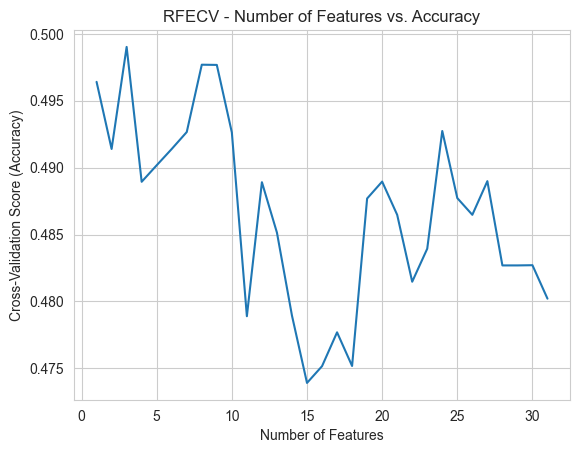

In [65]:
results_logreg = ModelFinder(X_train, y_train, LogisticRegression(max_iter=500, random_state = 101), {'C': [0.0001, 0.001, 0.001, 0.1, 1, 10, 100]})

In [66]:
results_logreg

{'n_features': 7,
 'accuracy_score': 0.539003164556962,
 'best_params': {'C': 10},
 'selected_features_indices': array([ 3,  6,  9, 24, 25, 26, 31], dtype=int64),
 'selected_features_mask': array([False, False, False,  True, False, False,  True, False, False,
         True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False,  True,  True,  True,
        False, False, False, False,  True, False, False, False])}

In [102]:
X_train_selected = X_train.iloc[:,results_logreg['selected_features_indices'] ]
X_test_selected = X_test.iloc[:,results_logreg['selected_features_indices'] ]
X_train_selected.columns

Index(['Age', 'Smoking', 'Nutritional_Deficiencies_Magnesium deficiency',
       'Medications&Treatments_Rogaine', 'Medications&Treatments_Steroids',
       'Medical_Conditions_Androgenetic Alopecia',
       'Medical_Conditions_Ringworm'],
      dtype='object')

In [103]:
logreg = LogisticRegression(C = 10,random_state= 101).fit(X_train_selected, y_train).fit(X_train_selected, y_train)   

Information for test data
              precision    recall  f1-score   support

           0       0.46      0.49      0.48        99
           1       0.46      0.43      0.44       101

    accuracy                           0.46       200
   macro avg       0.46      0.46      0.46       200
weighted avg       0.46      0.46      0.46       200

Information for train data
              precision    recall  f1-score   support

           0       0.56      0.60      0.58       403
           1       0.56      0.53      0.54       395

    accuracy                           0.56       798
   macro avg       0.56      0.56      0.56       798
weighted avg       0.56      0.56      0.56       798



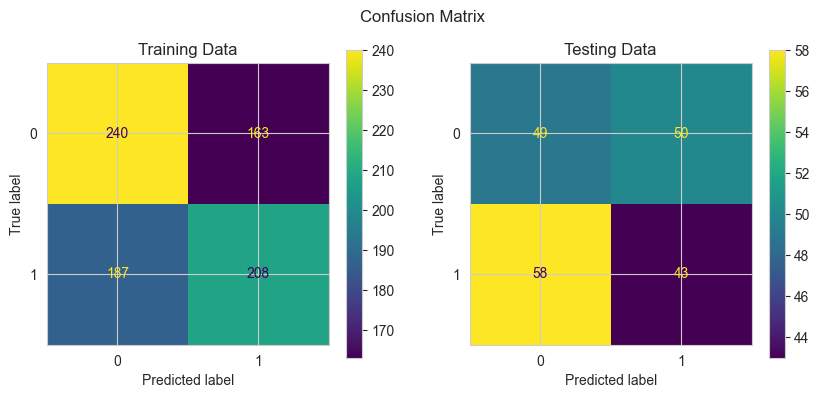

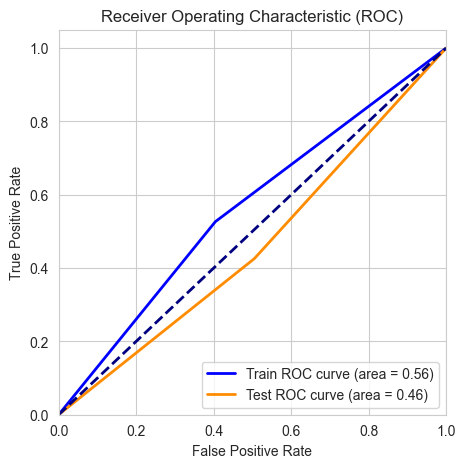

In [118]:
 printInformation(X_train_selected, y_train, X_test_selected, y_test, logreg)

Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.


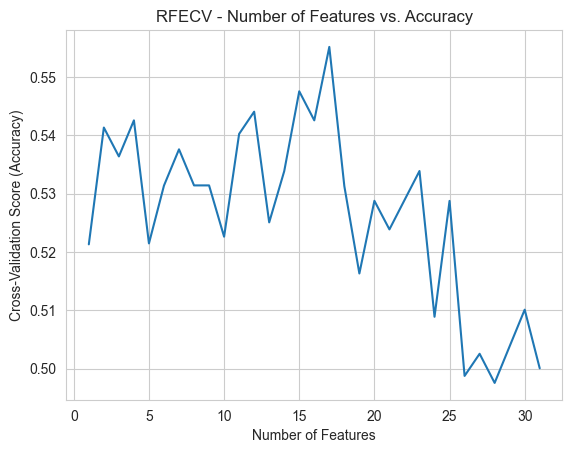

In [70]:
results_tree = ModelFinder(X_train, y_train, DecisionTreeClassifier(random_state= 101),
                        { 'max_depth': [2 * x for x in range(2,8)], 
                         'criterion':['gini','entropy']})

In [71]:
results_tree

{'n_features': 21,
 'accuracy_score': 0.5476424050632911,
 'best_params': {'criterion': 'entropy', 'max_depth': 8},
 'selected_features_indices': array([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 10, 16, 20, 21, 22, 23, 24, 25,
        30, 31, 32, 34], dtype=int64),
 'selected_features_mask': array([ True,  True,  True,  True,  True,  True,  True,  True, False,
         True,  True, False, False, False, False, False,  True, False,
        False, False,  True,  True,  True,  True,  True,  True, False,
        False, False, False,  True,  True,  True, False,  True])}

In [72]:
X_train_selected = X_train.iloc[:,results_tree['selected_features_indices'] ]
X_test_selected = X_test.iloc[:,results_tree['selected_features_indices'] ]
X_train_selected.columns

Index(['Genetics', 'Hormonal_Changes', 'Stress', 'Age',
       'Poor_Hair_Care_Habits', 'Environmental_Factors', 'Smoking',
       'Weight_Loss', 'Nutritional_Deficiencies_Magnesium deficiency',
       'Nutritional_Deficiencies_Omega-3 fatty acids',
       'Nutritional_Deficiencies_Zinc Deficiency',
       'Medications&Treatments_Blood Pressure Medication',
       'Medications&Treatments_Chemotherapy',
       'Medications&Treatments_Heart Medication ',
       'Medications&Treatments_Immunomodulators',
       'Medications&Treatments_Rogaine', 'Medications&Treatments_Steroids',
       'Medical_Conditions_Psoriasis', 'Medical_Conditions_Ringworm',
       'Medical_Conditions_Scalp Infection',
       'Medical_Conditions_Thyroid Problems'],
      dtype='object')

In [108]:
tree = DecisionTreeClassifier(random_state= 101, criterion = 'entropy', max_depth= 8).fit(X_train_selected,y_train)

Information for test data
              precision    recall  f1-score   support

           0       0.47      0.58      0.52        99
           1       0.47      0.38      0.42       101

    accuracy                           0.48       200
   macro avg       0.47      0.48      0.47       200
weighted avg       0.47      0.47      0.47       200

Information for train data
              precision    recall  f1-score   support

           0       0.63      0.73      0.68       403
           1       0.67      0.57      0.62       395

    accuracy                           0.65       798
   macro avg       0.65      0.65      0.65       798
weighted avg       0.65      0.65      0.65       798



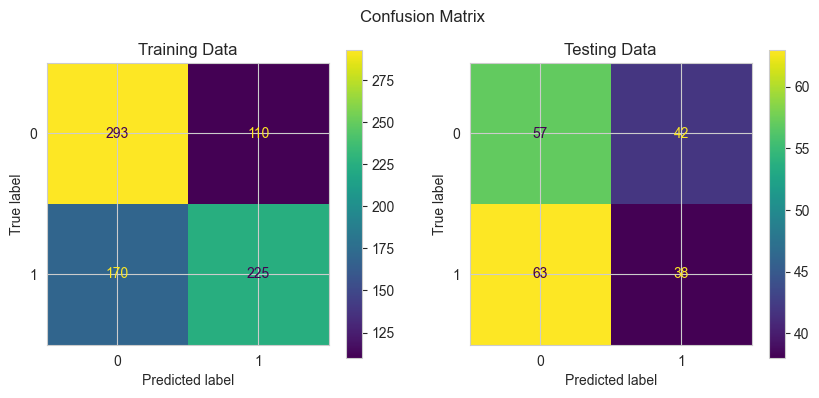

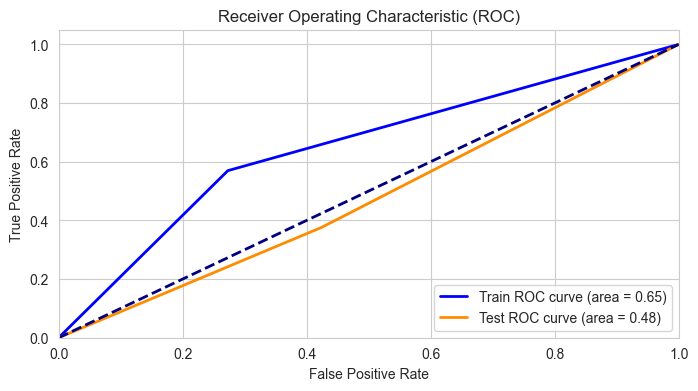

In [109]:
printInformation(X_train_selected, y_train, X_test_selected, y_test, tree)

Fitting estimator with 35 features.
Fitting estimator with 34 features.


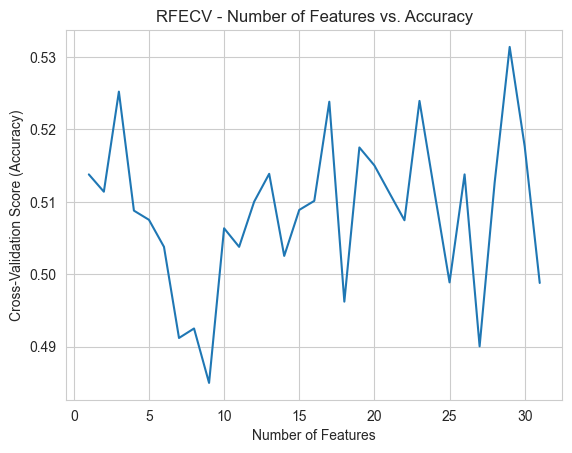

In [75]:
results_forest = ModelFinder(X_train, y_train, RandomForestClassifier(random_state=101),
                             {
                                'n_estimators': [5, 10, 50, 100, 200],  # Liczba drzew
                                'max_depth': [2 * x for x in range(2,8)],  # Maksymalna głębokość drzewa
                                'criterion' :['gini', 'entropy']
                            })

In [76]:
results_forest

{'n_features': 33,
 'accuracy_score': 0.5389398734177215,
 'best_params': {'criterion': 'entropy', 'max_depth': 14, 'n_estimators': 5},
 'selected_features_indices': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 33, 34],
       dtype=int64),
 'selected_features_mask': array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False, False,  True,  True])}

In [77]:
X_train_selected = X_train.iloc[:,results_forest['selected_features_indices'] ]
X_test_selected = X_test.iloc[:,results_forest['selected_features_indices'] ]
X_train_selected.columns

Index(['Genetics', 'Hormonal_Changes', 'Stress', 'Age',
       'Poor_Hair_Care_Habits', 'Environmental_Factors', 'Smoking',
       'Weight_Loss', 'Nutritional_Deficiencies_Iron deficiency',
       'Nutritional_Deficiencies_Magnesium deficiency',
       'Nutritional_Deficiencies_Omega-3 fatty acids',
       'Nutritional_Deficiencies_Protein deficiency',
       'Nutritional_Deficiencies_Selenium deficiency',
       'Nutritional_Deficiencies_Vitamin A Deficiency',
       'Nutritional_Deficiencies_Vitamin D Deficiency',
       'Nutritional_Deficiencies_Vitamin E deficiency',
       'Nutritional_Deficiencies_Zinc Deficiency',
       'Medications&Treatments_Antibiotics',
       'Medications&Treatments_Antidepressants ',
       'Medications&Treatments_Antifungal Cream',
       'Medications&Treatments_Blood Pressure Medication',
       'Medications&Treatments_Chemotherapy',
       'Medications&Treatments_Heart Medication ',
       'Medications&Treatments_Immunomodulators',
       'Medications&

In [110]:
forest = RandomForestClassifier(random_state=101, max_depth= 14, criterion= 'entropy',  n_estimators = 5).fit(X_train_selected,y_train)

Information for test data
              precision    recall  f1-score   support

           0       0.48      0.45      0.47        99
           1       0.49      0.51      0.50       101

    accuracy                           0.48       200
   macro avg       0.48      0.48      0.48       200
weighted avg       0.48      0.48      0.48       200

Information for train data
              precision    recall  f1-score   support

           0       0.76      0.67      0.71       403
           1       0.70      0.79      0.74       395

    accuracy                           0.73       798
   macro avg       0.73      0.73      0.72       798
weighted avg       0.73      0.73      0.72       798



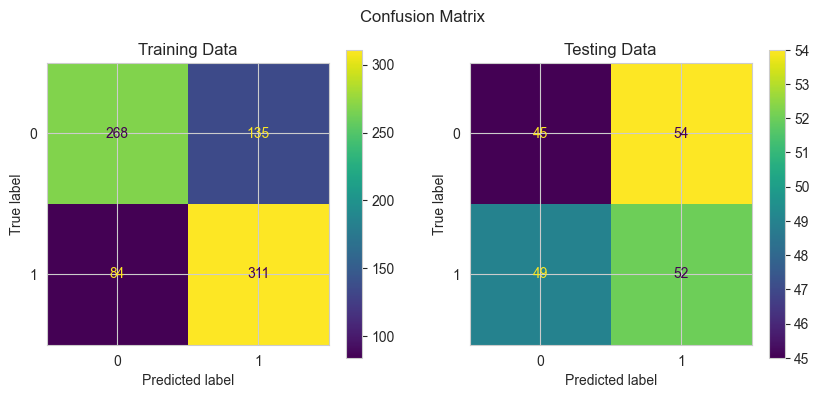

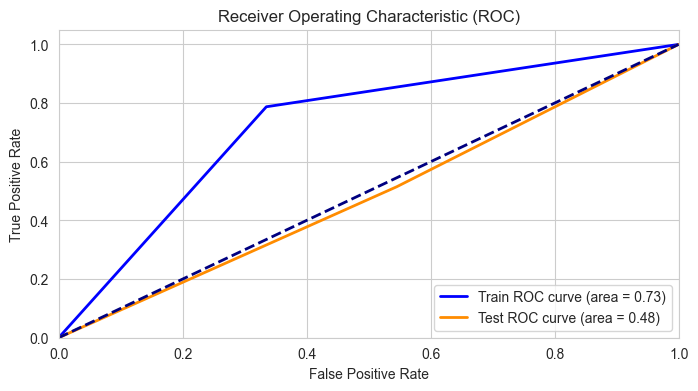

In [111]:
printInformation(X_train_selected, y_train, X_test_selected, y_test, forest)

Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.


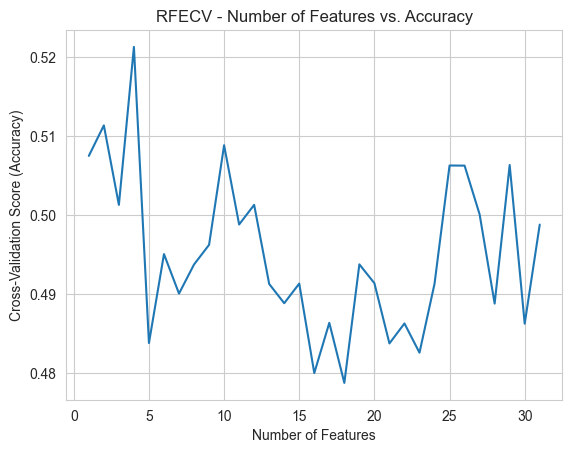

In [80]:
results_gbc = ModelFinder(X_train, y_train, GradientBoostingClassifier(random_state=101),
                             {
                                'n_estimators': [5, 10, 50, 100, 200],  # Liczba drzew
                                'max_depth': [2 * x for x in range(2,8)],  # Maksymalna głębokość drzewa
                                'criterion' :['friedman_mse', 'squared_error'],
                                 'learning_rate': [ 0.025, 0.05, 0.1, 0.2]
                                 
                            })

In [81]:
results_gbc

{'n_features': 8,
 'accuracy_score': 0.5550791139240507,
 'best_params': {'criterion': 'friedman_mse',
  'learning_rate': 0.1,
  'max_depth': 4,
  'n_estimators': 200},
 'selected_features_indices': array([ 0,  1,  3,  8, 16, 23, 26, 31], dtype=int64),
 'selected_features_mask': array([ True,  True, False,  True, False, False, False, False,  True,
        False, False, False, False, False, False, False,  True, False,
        False, False, False, False, False,  True, False, False,  True,
        False, False, False, False,  True, False, False, False])}

In [82]:
X_train_selected = X_train.iloc[:,results_gbc['selected_features_indices'] ]
X_test_selected = X_test.iloc[:,results_gbc['selected_features_indices'] ]
X_train_selected.columns

Index(['Genetics', 'Hormonal_Changes', 'Age',
       'Nutritional_Deficiencies_Iron deficiency',
       'Nutritional_Deficiencies_Zinc Deficiency',
       'Medications&Treatments_Immunomodulators',
       'Medical_Conditions_Androgenetic Alopecia',
       'Medical_Conditions_Ringworm'],
      dtype='object')

In [112]:
gbc = GradientBoostingClassifier(random_state=101, max_depth= 4, criterion= 'friedman_mse',  n_estimators = 200, learning_rate = 0.1).fit(X_train_selected,y_train)

Information for test data
              precision    recall  f1-score   support

           0       0.47      0.51      0.49        99
           1       0.47      0.44      0.45       101

    accuracy                           0.47       200
   macro avg       0.47      0.47      0.47       200
weighted avg       0.47      0.47      0.47       200

Information for train data
              precision    recall  f1-score   support

           0       0.74      0.72      0.73       403
           1       0.72      0.74      0.73       395

    accuracy                           0.73       798
   macro avg       0.73      0.73      0.73       798
weighted avg       0.73      0.73      0.73       798



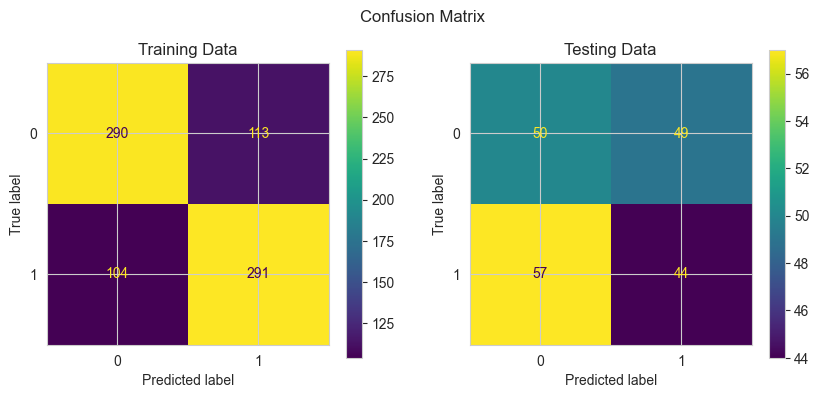

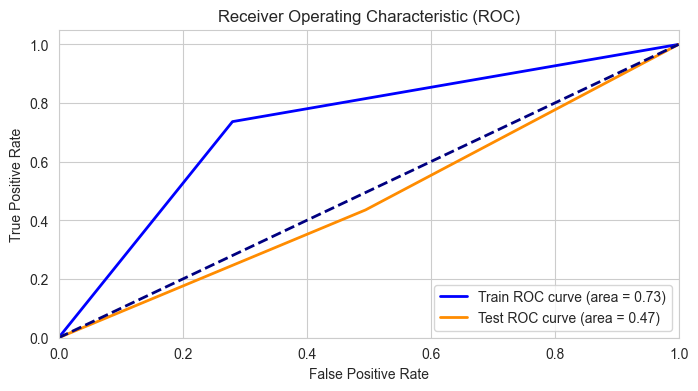

In [113]:
printInformation(X_train_selected, y_train, X_test_selected, y_test, gbc)

In [85]:
results_knc = ModelFinder(X_train, y_train, KNeighborsClassifier(),
                             {
                                'weights': ['uniform', 'distance'],  # Liczba drzew
                                'n_neighbors': [5, 7, 9, 11, 15, 33, 66, 99],
                                
                                 'metric': ['euclidean', 'manhattan']
                                 
                            })

The estimator does not directly support RFECV. Using the full feature set.


In [86]:
results_knc

{'n_features': 'N/A',
 'accuracy_score': 0.5137025316455696,
 'best_params': {'metric': 'manhattan',
  'n_neighbors': 9,
  'weights': 'distance'}}

In [87]:
knc = KNeighborsClassifier(n_neighbors= 9, weights='distance', metric = 'manhattan' ).fit(X_train, y_train)

Information for test data
              precision    recall  f1-score   support

           0       0.52      0.49      0.51        99
           1       0.52      0.54      0.53       101

    accuracy                           0.52       200
   macro avg       0.52      0.52      0.52       200
weighted avg       0.52      0.52      0.52       200

Information for train data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       403
           1       1.00      1.00      1.00       395

    accuracy                           1.00       798
   macro avg       1.00      1.00      1.00       798
weighted avg       1.00      1.00      1.00       798



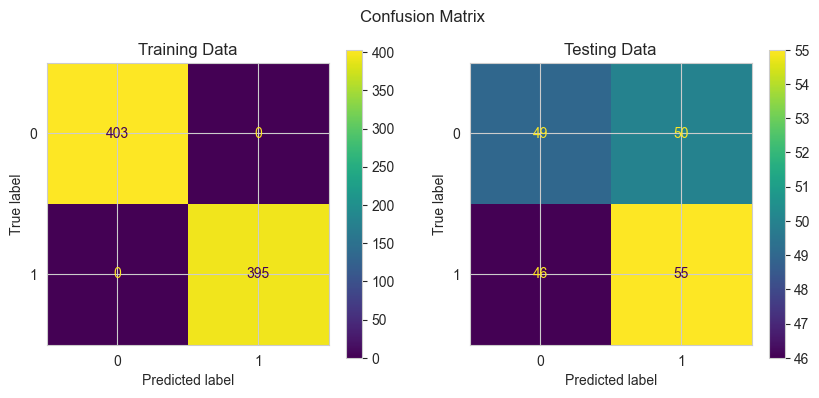

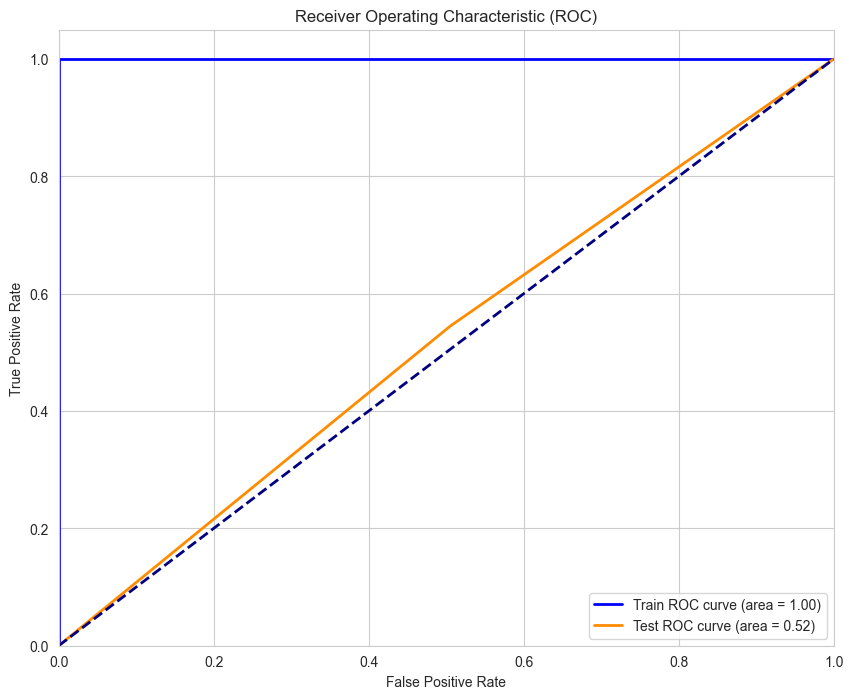

In [99]:
printInformation(X_train, y_train, X_test, y_test, knc)

In [89]:
results_svc = ModelFinder(X_train, y_train, SVC(random_state=101),
                             {
    'C': [0.1, 1, 10, 100],  # Parametr regularyzacji
    'gamma': [1, 0.1, 0.01, 0.001],  # Parametr dla 'rbf', 'poly' i 'sigmoid'
    'kernel': ['rbf', 'poly', 'sigmoid']  # Typ jądra
                                 
                            })

The estimator does not directly support RFECV. Using the full feature set.


In [90]:
results_svc

{'n_features': 'N/A',
 'accuracy_score': 0.5199525316455695,
 'best_params': {'C': 10, 'gamma': 0.1, 'kernel': 'sigmoid'}}

In [91]:
svc = SVC(random_state=101, C = 10, gamma = 0.1, kernel='sigmoid').fit(X_train, y_train) 

Information for test data
              precision    recall  f1-score   support

           0       0.49      0.45      0.47        99
           1       0.50      0.53      0.52       101

    accuracy                           0.49       200
   macro avg       0.49      0.49      0.49       200
weighted avg       0.49      0.49      0.49       200

Information for train data
              precision    recall  f1-score   support

           0       0.51      0.53      0.52       403
           1       0.50      0.49      0.50       395

    accuracy                           0.51       798
   macro avg       0.51      0.51      0.51       798
weighted avg       0.51      0.51      0.51       798



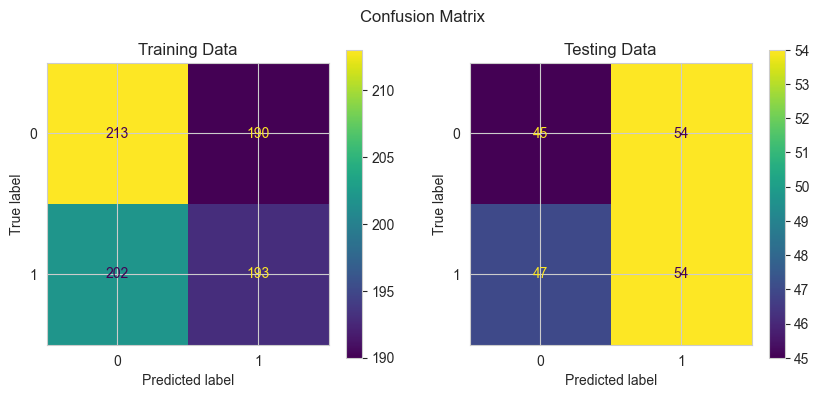

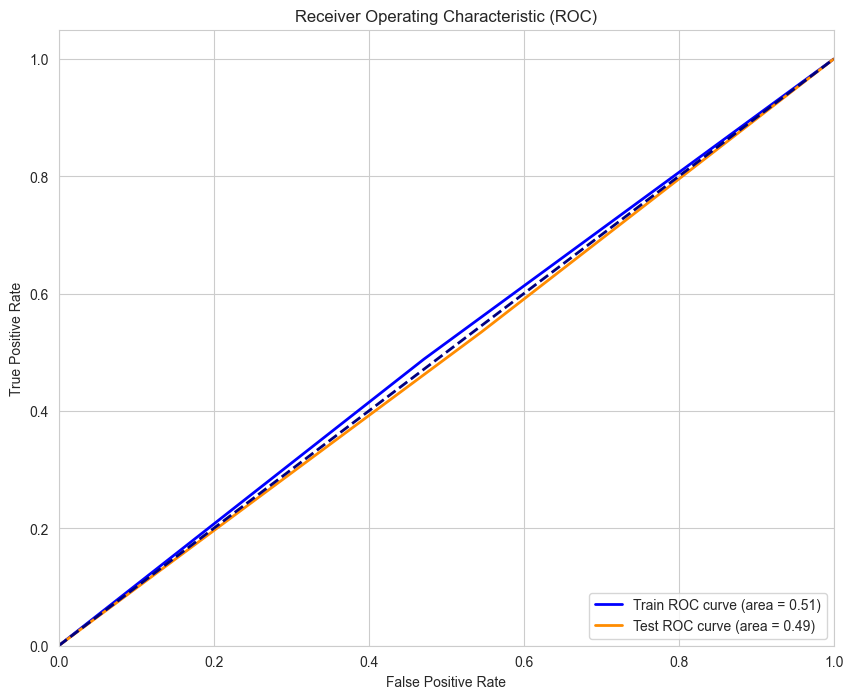

In [92]:
printInformation(X_train, y_train, X_test, y_test, svc)

In [93]:
results_naive = ModelFinder(X_train, y_train, BernoulliNB(),
                             {
    'alpha': [0.01, 0.1, 1.0, 10.0],  # Parametr wygładzania
    'binarize': [0.0, 0.1, 0.2],  # Próg dla binaryzacji cech
})


The estimator does not directly support RFECV. Using the full feature set.


In [94]:
results_naive

{'n_features': 'N/A',
 'accuracy_score': 0.47501582278481014,
 'best_params': {'alpha': 0.1, 'binarize': 0.1}}

In [114]:
naive = BernoulliNB( alpha = 0.1, binarize= 0.1).fit(X_train, y_train)

Information for test data
              precision    recall  f1-score   support

           0       0.51      0.60      0.55        99
           1       0.53      0.45      0.48       101

    accuracy                           0.52       200
   macro avg       0.52      0.52      0.52       200
weighted avg       0.52      0.52      0.52       200

Information for train data
              precision    recall  f1-score   support

           0       0.59      0.61      0.60       403
           1       0.58      0.56      0.57       395

    accuracy                           0.59       798
   macro avg       0.59      0.59      0.58       798
weighted avg       0.59      0.59      0.59       798



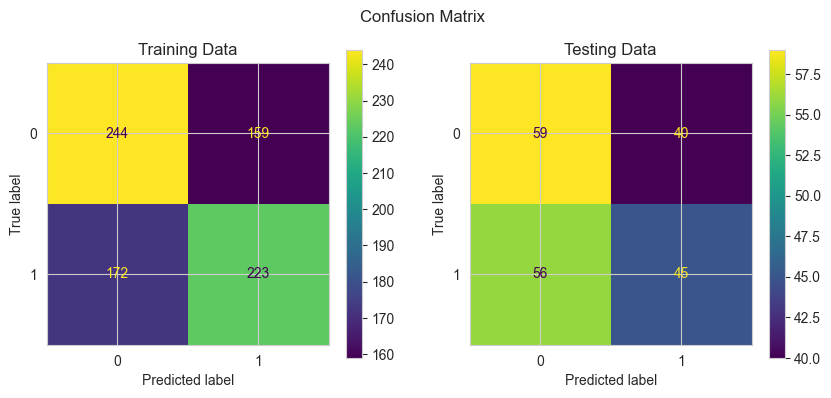

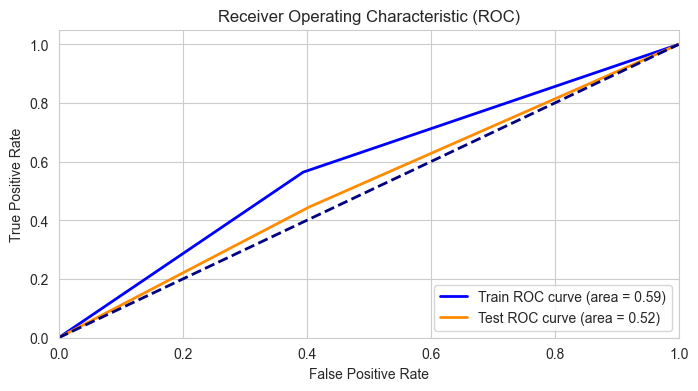

In [115]:
printInformation(X_train, y_train, X_test, y_test, naive)